# Neural Data Analysis

## 1. Population Vectors
Estimating movement directions from monkey motor cortex recordings.

In [221]:
# load spiking models and analysis techniques
from compneuro import *
# set seed for reproducibility
np.random.seed(1337)

## a) Compute tuning curve of each neuron from train data and save params $r_0, F_1, \theta_{pref}$ for each unit.

In [222]:
# read in the train data
go_info = np.loadtxt('Assignment_04_data/train/go.txt')
direction = np.loadtxt('Assignment_04_data/train/direction.txt')

# hold all the go cues organized by which direction they correspond to
directions = [1,2,3,4,5,6,7,8]
big_indicies = [np.where(direction == d) for d in directions]
go_cues = [go_info[i] for i in big_indicies]

In [223]:
# curve fitting functionality
from scipy.optimize import curve_fit

def cosine_fit(x, r0, F1, theta_pref):
    """
    Cosine functionality to help fit a curve

    Parameters
    -----------
    x: float
        angle
    r0: float
        background rate
    F1: float
        amplitude
    theta_pref: float
        shift in angle
    
    Returns
    -------
    float
        cosine function with params given evaluated at x

    """
    return r0 + F1*np.cos(((x - theta_pref)*np.pi)/(180))

def fixPopt(arr):
    """
    Function fixes the scipy optimize output for cosine fitting.

    Parameters
    -----------
    arr : list of fitted parameters given by scipy.optimize.curve_fit

    Returns
    -------
    list
        Fixed fitted params
    """

    r0 = arr[0]
    F1 = arr[1]
    theta_pref = arr[2]
    if F1 < 0:
        F1 = -F1
        theta_pref = (theta_pref + 180) % 360
    elif theta_pref > 360 or theta_pref < 0:
        theta_pref = theta_pref % 360
    return [r0, F1, theta_pref]

In [224]:

r0, F1, theta_pref = [], [], []
angles = np.array([0, 45, 90, 135, 180, 225, 270, 315])
for i in range(143):
    neuron = np.loadtxt(f"Assignment_04_data/train/spike_trains/spike_train_unit_{i:03}.txt")
    if len(neuron) == 0:
        r0.append(0)
        F1.append(0)
        theta_pref.append(0)
    else:
        average_rates = []
        # find the trial average rate for each direction
        for dir in go_cues:
            rate_holder = []
            for cue in dir:
                idxs = np.where((0 <= neuron - cue) & (neuron - cue <= 1))
                rate_holder.append(len(neuron[idxs]))
            average_rates.append(sum(rate_holder) / len(rate_holder))
        popt, pcov = curve_fit(cosine_fit, angles, average_rates)
        popt = fixPopt(popt)
        r0.append(popt[0])
        F1.append(popt[1])
        theta_pref.append(popt[2])

/tmp/ipykernel_478438/3268603836.py:4: UserWarning: loadtxt: input contained no data: "Assignment_04_data/train/spike_trains/spike_train_unit_023.txt"
  neuron = np.loadtxt(f"Assignment_04_data/train/spike_trains/spike_train_unit_{i:03}.txt")


## b) Compute population vector estimates using the test data

In [225]:
# read in the test data
go_info_test = np.loadtxt('Assignment_04_data/test/go.txt')
direction_test = np.loadtxt('Assignment_04_data/test/direction.txt')
# hold all the go cues organized by which direction they correspond to
# directions = [1,2,3,4,5,6,7,8]
# big_indicies_test = [np.where(direction == d) for d in directions]
# go_cues_test = [go_info[i] for i in big_indicies]

In [226]:
# hold the ground truth angle and the population prediction
true_angle = []
pred_angle = []

# load neuron data once into memory to prevent having to read from disk multiple times
neuron_data_test = []
for i in range(143):
    neuron_data_test.append(np.loadtxt(f"Assignment_04_data/test/spike_trains/spike_train_unit_{i:03}.txt"))

for m in range(len(go_info_test)):
    cue = go_info_test[m]
    # compute firing rate of each neuron during the period [0,1] seconds relative to the go cue for each trial
    pop_vector = np.zeros((1,2))
    for i in range(143):
        neuron = neuron_data_test[i]
        if len(neuron) == 0:
            pass
        else:
            idxs = np.where((0 <= neuron - cue) & (neuron - cue <= 1))
            r_i_j = len(neuron[idxs])
            w_i = r_i_j - r0[i]
            C_i = np.asarray([np.cos(theta_pref[i] * (2*np.pi/360)), np.sin(theta_pref[i] * (2*np.pi)/360)])
            part = w_i * C_i
            pop_vector += part
    
    theta_j_est = np.arctan2(pop_vector[0,1], pop_vector[0,0]) * (180/np.pi) % 360
    pred_angle.append(theta_j_est.item())
    true_angle.append((direction_test[m].item() - 1) * 45)

/tmp/ipykernel_478438/865222603.py:8: UserWarning: loadtxt: input contained no data: "Assignment_04_data/test/spike_trains/spike_train_unit_023.txt"
  neuron_data_test.append(np.loadtxt(f"Assignment_04_data/test/spike_trains/spike_train_unit_{i:03}.txt"))


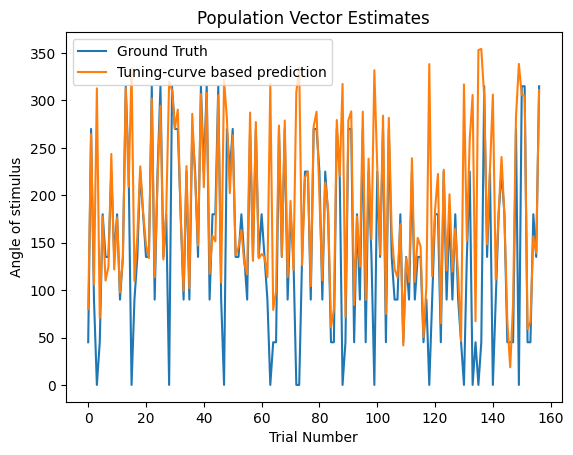

In [227]:
# plot estimated direction vs actual direction for each trial
plt.plot(true_angle, label='Ground Truth');
plt.plot(pred_angle, label='Tuning-curve based prediction');
plt.xlabel("Trial Number");
plt.ylabel("Angle of stimulus");
plt.title("Population Vector Estimates")
plt.legend();

## c) Bin predicted direction to compare with the eight discrete stimulus angles

In [228]:
def binPrediction(angle: float):
    """
    Discretize angle values

    Parameters
    -------
    angle: float
        angle from 0 to 360 degrees
    
    Returns
    -------
    float
        [0:45:360] closest to angle
    """
    diffs = np.abs(angles - angle)
    minIdx = np.argmin(diffs)
    if angle > 337.5:
        return 0
    else:
        return angles[minIdx].item()

discretized_pred_angles = [binPrediction(el) for el in pred_angle]
count_correct = 0
for i in range(len(discretized_pred_angles)):
    if discretized_pred_angles[i] == true_angle[i]:
        count_correct += 1
print(f"Accuracy: {count_correct/len(discretized_pred_angles)}")

Accuracy: 0.7006369426751592


# 2. Discrimination Analysis

## a) Plotting the fraction of correct trials as a function of d.

In [229]:
r_minus = 20
sigma_r = 10

stimuli = []
rate_resp = []
accuracy_by_d = []

for d in range(11):
    r_plus = 20 + sigma_r * d
    correct_count = 0
    stimuli.append([])
    rate_resp.append([])
    
    for i in range(1000):
        flip = np.random.rand() > 0.5
        if flip:
            # usei s_plius
            r = np.random.normal(r_plus, sigma_r)
            stimuli[d].append(1)
        else:
            # use s_minus
            r = np.random.normal(r_minus, sigma_r)
            stimuli[d].append(0)

        if r < 0:
            r = 0

        rate_resp[d].append(r)

        # threshold value
        z = 20 + 5*d
        if r >= z:
            if flip:
                correct_count += 1
        else:
            if not flip:
                correct_count += 1
    accuracy_by_d.append(correct_count / 1000)

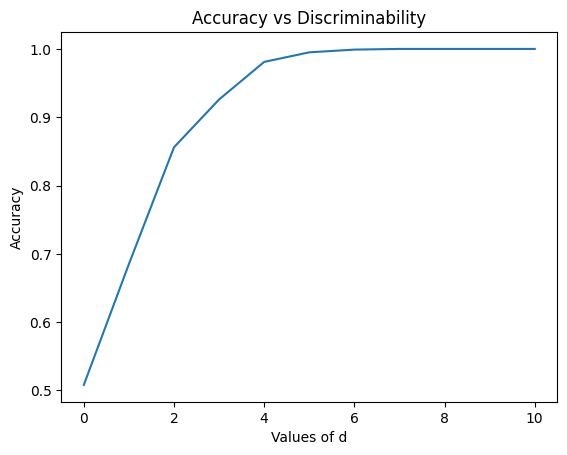

In [230]:
plt.plot(accuracy_by_d);
plt.xlabel("Values of d");
plt.ylabel("Accuracy");
plt.title("Accuracy vs Discriminability");

## b) ROC curves of discriminability

In [231]:
# true and false positive rates
tprs = []
fprs = []

for d in range(6):
    tprs.append([])
    fprs.append([])
    for z in range(141):
        true_positive_count = 0
        true_negative_count = 0
        false_positive_count = 0
        false_negative_count = 0

        for i in range(len(rate_resp[d])):
            rate = rate_resp[d][i]
            if rate >= z:
                # predicted positive
                if stimuli[d][i] == 1:
                    # stimulus was s_plus
                    true_positive_count += 1
                else:
                    false_positive_count += 1
            else:
                # predicted negative
                if stimuli[d][i] == 1:
                    # stimulus was s_plus
                    false_negative_count += 1
                else:
                    true_negative_count += 1

        tprs[d].append(true_positive_count / (true_positive_count + false_negative_count))
        fprs[d].append(false_positive_count / (false_positive_count + true_negative_count))

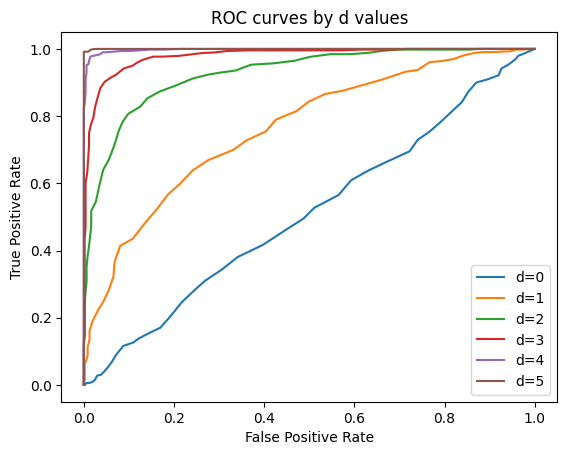

In [232]:
# graph ROC curves
for d in range(6):
    plt.plot(fprs[d],tprs[d], label=f"d={d}")
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title("ROC curves by d values")
plt.legend();

## c) AUC (Area Under Curve) for each ROC curve

In [233]:
aucs = []
for d in range(6):
    acc = 0
    for i in range(1,len(fprs[d])):
        # using approximation
        acc += tprs[d][i]*(fprs[d][i-1]-fprs[d][i])
    aucs.append(acc)

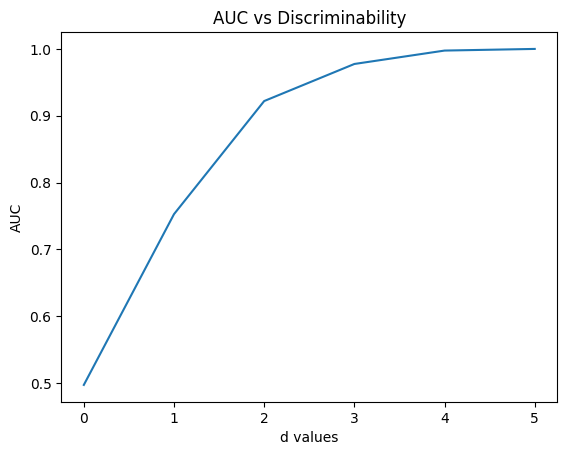

In [234]:
# graphing aucs
plt.plot([i for i in range(6)], aucs)
plt.xlabel("d values");
plt.ylabel("AUC");
plt.title("AUC vs Discriminability");

## d) Relationship between ROC curves and AUC with discriminability d
As d increases and the firing rate distributions for the two stimuli grow farther apart, the threshold-based prediction model becomes more and more accurate, as evidenced by the increasing AUCs for ROC curves at higher d values. An AUC of 0.5 means a no better than random guessing. An AUC of 1 means perfect prediction capability. The neuron's ability to separate stimuli is positively correlated with the AUC - as the AUC increases, the neurons become better at accurately separating stimuli.

# 3. Entropy Measures

## a) Computing the entropy for all responses for all values of d.

In [235]:
r_minus = 20
sigma_r = 10
entropies = []
bins = np.arange(-10,140,2)
r_ps = []
r_ms = []
for d in range(11):
    r_plus = 20 + sigma_r * d

    # generate the rates for all trials
    flips = np.random.rand(1000) > 0.5
    invflips = np.invert(flips)

    r_pluses = np.random.normal(r_plus, sigma_r, size=1000)
    r_minuses = np.random.normal(r_minus, sigma_r, size=1000)

    r_p = r_pluses[flips]
    r_m = r_minuses[invflips]

    # save for later
    r_ps.append(r_p)
    r_ms.append(r_m)

    full_trials = np.concatenate((r_p, r_m))

    # find binned probability distribution of the stimulus for this d
    hist, _ = np.histogram(full_trials, bins=bins)

    # remove bins with zero elements
    hist = hist[hist > 0]

    # create probability distribution
    prob_dist = hist / hist.sum()
    intermed = prob_dist * np.log2(prob_dist)

    # multiply the p(r)log(p(r)) by how rates we have in that bin
    # intermed = intermed * hist

    H = -intermed.sum()
    entropies.append(H)

for i in range(11):
    print(f"entropy: {entropies[i]} for d = {i}")

entropy: 4.377116743288086 for d = 0
entropy: 4.485846425021339 for d = 1
entropy: 4.7847578212845105 for d = 2
entropy: 5.115851562191409 for d = 3
entropy: 5.209524376585563 for d = 4
entropy: 5.297878628684386 for d = 5
entropy: 5.264699473458637 for d = 6
entropy: 5.3244774096317835 for d = 7
entropy: 5.361946323322159 for d = 8
entropy: 5.296046416921914 for d = 9
entropy: 5.21111721868152 for d = 10


## b) Computing the conditional entropy $H(R|S)$

In [236]:
conditional_entropies = []
for d in range(11):
    # find binned probability distribution of both stimuli for this d
    hist_p, _ = np.histogram(r_ps[d],bins=bins)
    hist_m, _ = np.histogram(r_ms[d],bins=bins)

    # remove bins with zero elements
    hist_p = hist_p[hist_p > 0]
    hist_m = hist_m[hist_m > 0]

    # create probability distributions
    prob_dist_p = hist_p / hist_p.sum()
    prob_dist_m = hist_m / hist_m.sum()

    intermed_p = prob_dist_p * np.log2(prob_dist_p)
    intermed_m = prob_dist_m * np.log2(prob_dist_m)

    # multiply the p(r)log(p(r)) by how rates we have in that bin
    # intermed_p = intermed_p * hist_p
    # intermed_m = intermed_m * hist_m

    H_p = -intermed_p.sum()
    H_m = -intermed_m.sum()

    # multiply by priors for conditional entropy
    conditional_entropies.append(H_p * 0.5 + H_m * 0.5)

for i in range(11):
    print(f"conditional entropies: {conditional_entropies[i]} for d = {i}")

conditional entropies: 4.351867543737336 for d = 0
conditional entropies: 4.311252578360347 for d = 1
conditional entropies: 4.289816530213275 for d = 2
conditional entropies: 4.3737537963467386 for d = 3
conditional entropies: 4.280219026692739 for d = 4
conditional entropies: 4.3085579756116505 for d = 5
conditional entropies: 4.2696684663213365 for d = 6
conditional entropies: 4.3254729967964005 for d = 7
conditional entropies: 4.361961073518412 for d = 8
conditional entropies: 4.296816681787819 for d = 9
conditional entropies: 4.2113822754406005 for d = 10


## c) Computing the mutual information $I(S;R) = H(R) - H(R|S)$

In [237]:
mutual_info = []
for d in range(11):
    mutual_info.append(entropies[d] - conditional_entropies[d])

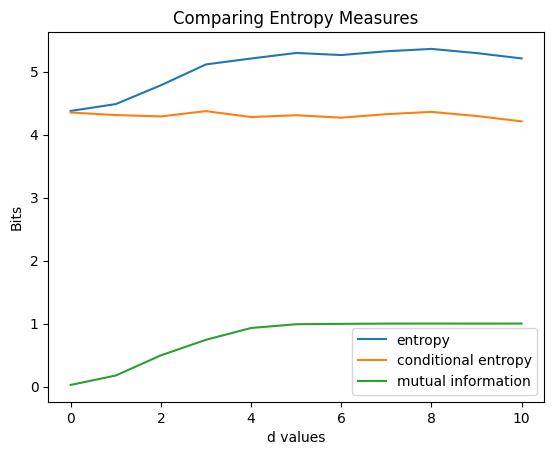

In [238]:
# plotting entropy, conditional entropy, and mutual information on a single plot
d = [i for i in range(11)]
plt.plot(d, entropies, label="entropy")
plt.plot(d, conditional_entropies, label="conditional entropy")
plt.plot(d, mutual_info, label="mutual information")
plt.xlabel("d values")
plt.ylabel("Bits")
plt.title("Comparing Entropy Measures")
plt.legend();

## d) Interpreting the relationship between entropy, conditional entropy, and mutual information as discriminability (the distance between distribution means) increases
As d increases, the distance between the two distributions for the different stimuli increases and the overlap between them shrinks. Therefore, the entropy of the combined distribution increases as d increases because it becomes more spread out. The conditional entropy doesn't change as d changes because the two distributions themselves don't change shape as d increases. The mutual information is the difference between the entropy and conditional entropy so when d is zero, I(S;R) is zero (so the distributions overlap completely - so knowing the rate gives us no helpful information about what the stimulus is) then increase as d increases. I(S;R) saturates at large d because once the distributions are separate enough we are almost certain which stimulus caused the rate we see - increasing the distance further doesn't help much. This matches the trend from the AUC curve in 2(c) because at high d we have a perfect prediction model that can confidently predict which stimulus caused the observed rate (AUC=1).